### Trực quan hoá đa biến để tìm ra các đặc trưng quan trọng cho quá trình training

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
mu_df = pd.read_csv("../../raw_data/clean_and_transformation/manchester_united.csv")

In [5]:
mu_df.columns

Index(['opponent', 'venue', 'season', 'date', 'time', 'result',
       'win_before_team1', 'lose_before_team1', 'draw_before_team1',
       'win_before_team2', 'lose_before_team2', 'draw_before_team2',
       'formation_team1', 'formation_team2', 'round', 'attendance', 'referee',
       'date_time', 'history_team1_win_team2', 'history_team1_draw_team2',
       'history_team1_lose_team2', 'is_opponent_big6'],
      dtype='object')

### 1. Xem xét sự ảnh hưởng của venue đến biến mục tiêu result

In [6]:
result_count = mu_df.groupby(['venue', 'result']).size().unstack().reindex(["W", "L", "D"], axis=1).reindex(["Home", "Away"])
venue_count = mu_df.groupby(['venue']).size().reindex(["Home", "Away"])

result_count

result,W,L,D
venue,,,
Home,304,56,77
Away,226,105,106


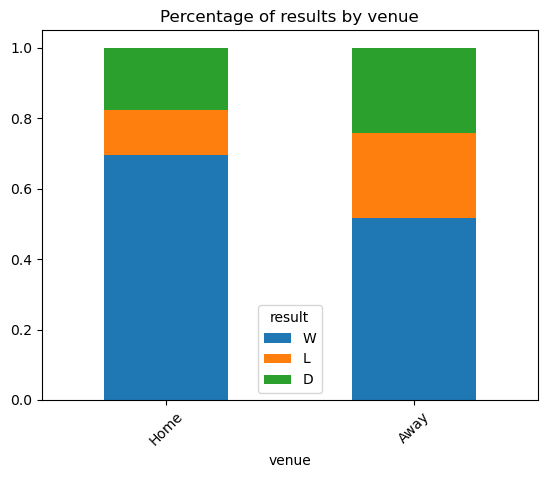

In [7]:
result_percentage = result_count.div(venue_count, axis=0)
result_percentage.plot(kind='bar', stacked=True)
plt.title("Percentage of results by venue")
plt.xticks(rotation=45);

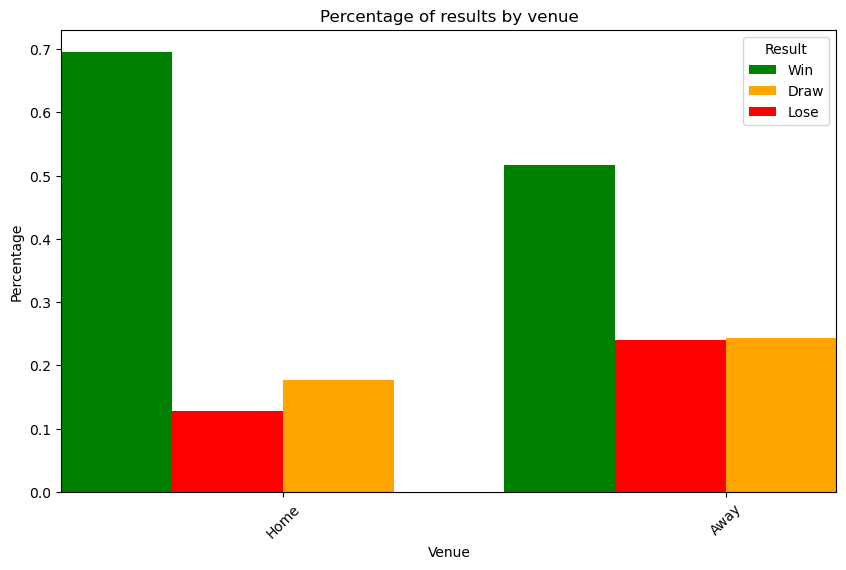

In [8]:
# Vẽ ba biểu đồ cột cho mỗi loại kết quả
fig, ax = plt.subplots(figsize=(10, 6))

# Vẽ biểu đồ cho kết quả Win
result_percentage['W'].plot(kind='bar', ax=ax, color='green', position=2, width=0.25, label='Win')

# Vẽ biểu đồ cho kết quả Draw
result_percentage['D'].plot(kind='bar', ax=ax, color='orange', position=0, width=0.25, label='Draw')

# Vẽ biểu đồ cho kết quả Lose
result_percentage['L'].plot(kind='bar', ax=ax, color='red', position=1, width=0.25, label='Lose')

plt.title("Percentage of results by venue")
plt.xlabel("Venue")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.legend(title='Result')

plt.show()

Nhận xét:
- Đá trên sân nhà luôn có tỉ lệ thắng, hoà cao hơn so với tỉ lệ thua. Tỉ lệ thắng là cao rõ rệt
- Còn khi đá trên sân khách thì tỉ lệ thắng có cao hơn so với tỉ lệ thua nhưng không rõ rệt như đá trên sân nhà, <br/>
và lúc này tỉ lệ thua lại cao hơn tỉ lệ hoà

### 2. Xem xét sự ảnh hưởng của referee đến biến mục tiêu result

In [7]:
result_by_referee = mu_df.groupby(['referee', 'result']).size().unstack().reindex(["W", "L", "D"], axis=1).dropna(axis=0)
match_count_by_referee = mu_df.groupby(['referee']).size()

In [8]:
result_by_referee.head()

result,W,L,D
referee,,,
Alan Wiley,15.0,6.0,6.0
Andre Marriner,22.0,11.0,6.0
Andy D'Urso,6.0,2.0,2.0
Anthony Taylor,23.0,12.0,4.0
Chris Foy,19.0,2.0,6.0


In [9]:
match_count_by_referee.head()

referee
Alan Wiley        27
Andre Marriner    39
Andy D'Urso       10
Andy Madley        4
Anthony Taylor    39
dtype: int64

In [10]:
result_by_referee_percentage = result_by_referee.div(match_count_by_referee, axis=0).dropna(axis=0)
result_by_referee_percentage.head()

result,W,L,D
referee,,,
Alan Wiley,0.555556,0.222222,0.222222
Andre Marriner,0.564103,0.282051,0.153846
Andy D'Urso,0.600000,0.200000,0.200000
Anthony Taylor,0.589744,0.307692,0.102564
Chris Foy,0.703704,0.074074,0.222222


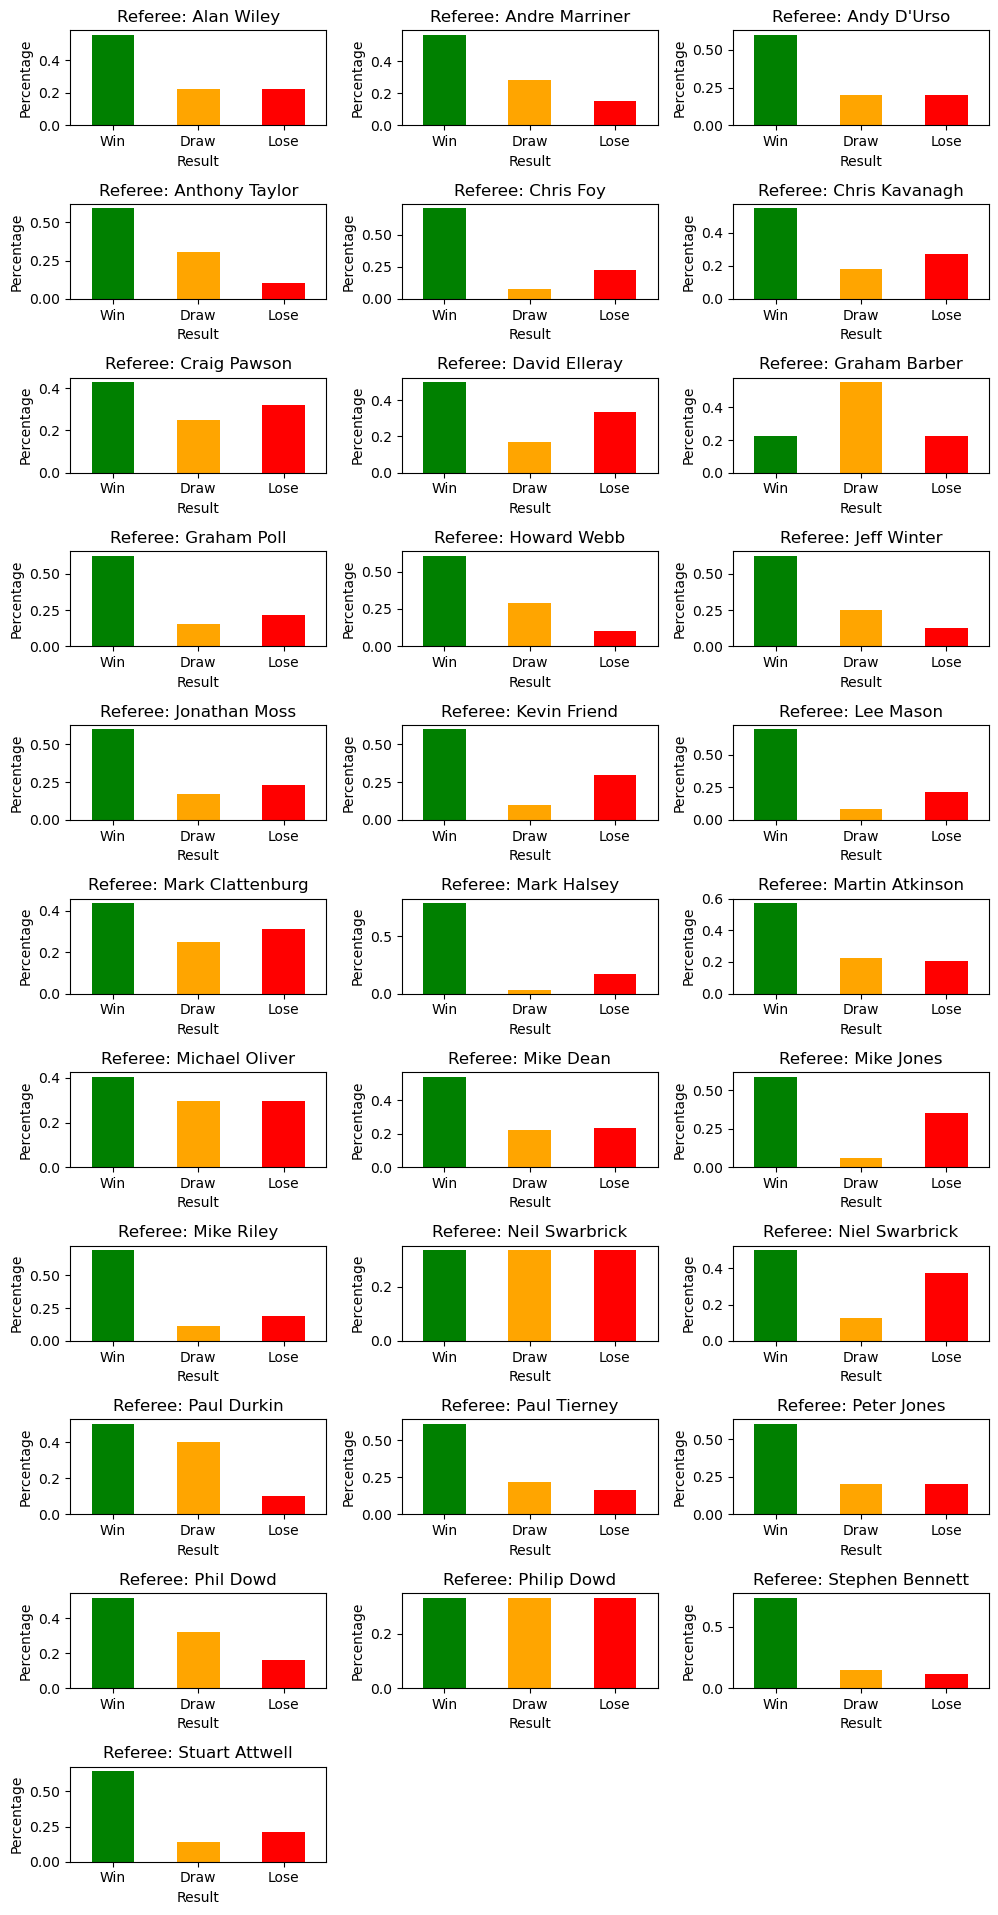

In [11]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Tạo GridSpec với số hàng và số cột tùy chọn
num_referees = len(result_by_referee_percentage.index)
num_cols = 3  # Số cột trong mỗi hàng
num_rows = -(-num_referees // num_cols)  # Số hàng được làm tròn lên

# Tạo GridSpec
gs = GridSpec(num_rows, num_cols)

# Vẽ nhiều đồ thị con trong một đồ thị lớn
fig = plt.figure(figsize=(10, 1.75* num_rows))  # Kích thước của đồ thị lớn
for i, referee in enumerate(result_by_referee_percentage.index):
    row = i // num_cols
    col = i % num_cols
    ax = fig.add_subplot(gs[row, col])
    
    # Vẽ biểu đồ cột cho từng trọng tài
    result_by_referee_percentage.loc[referee].plot(kind='bar', ax=ax, color=['green', 'orange', 'red'])
    
    ax.set_title(f"Referee: {referee}")
    ax.set_xlabel("Result")
    ax.set_ylabel("Percentage")
    ax.set_xticklabels(['Win', 'Draw', 'Lose'], rotation=0)
    
plt.tight_layout()
plt.show()

Nhận xét:
- Đại đa số các trận đấu đều có %W cao nhất và đại đa số %L cao hơn %D khi một trọng tài nào đó điều khiển trận đấu, điều này cho thấy rằng trọng tài không ảnh hưởng <br/>
nhiều đến kết quả trận đấu. Do đó sẽ không sử dụng biến referee trong quá trình training

### 3. Phong độ của 2 đội đến kết quả

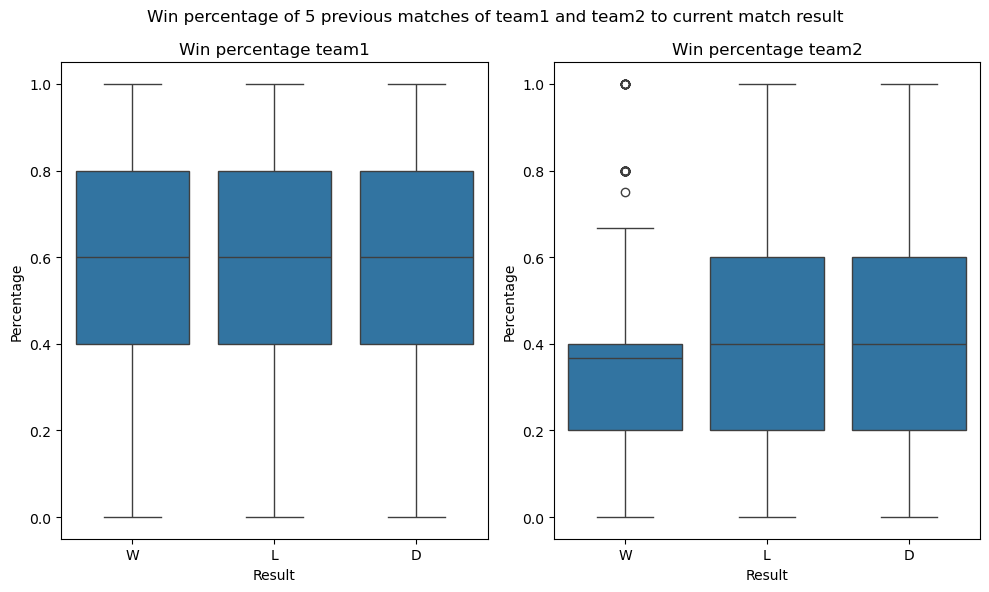

In [24]:
# Vẽ biểu đồ box plot thể hiện ảnh hưởng của tỷ lệ thắng 5 trận trước đó của 2 team đến kết quả trận đấu
order = ["W", "L", "D"]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

sns.boxplot(x="result", y="win_before_team1", data=mu_df, ax=axes[0], order=order)
axes[0].set_title("Win percentage team1")
axes[0].set_xlabel("Result")
axes[0].set_ylabel("Percentage")

sns.boxplot(x="result", y="win_before_team2", data=mu_df, ax=axes[1], order=order)
axes[1].set_title("Win percentage team2")
axes[1].set_xlabel("Result")
axes[1].set_ylabel("Percentage")

plt.suptitle(
    "Win percentage of 5 previous matches of team1 and team2 to current match result"
)
plt.tight_layout()

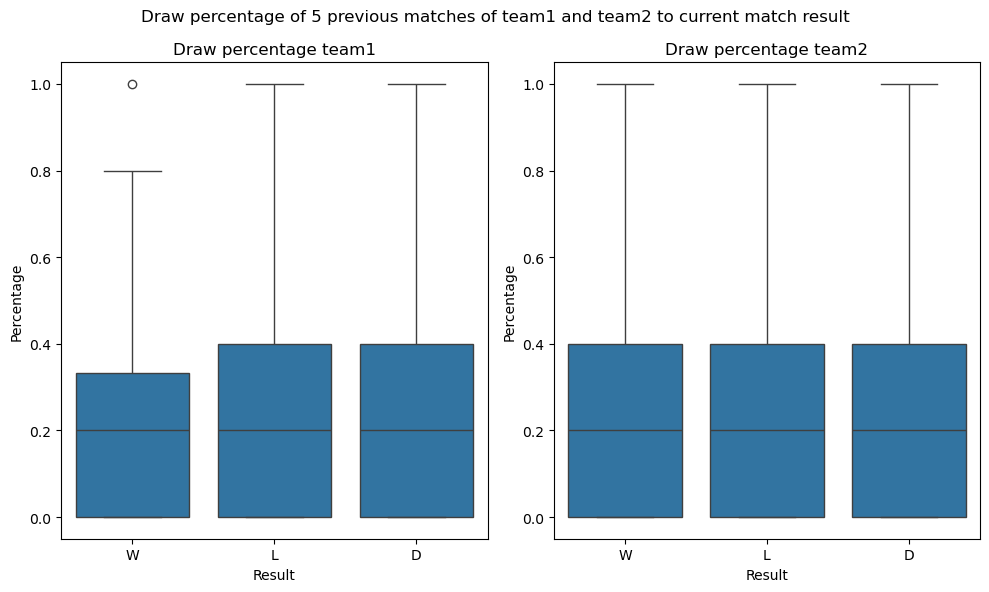

In [13]:
# Vẽ biểu đồ box plot thể hiện ảnh hưởng của tỷ lệ hoà 5 trận trước đó của 2 team đến kết quả trận đấu
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
order = ["W", "L", "D"]

sns.boxplot(x='result', y='draw_before_team1', data=mu_df, ax=axes[0], order=order)
axes[0].set_title('Draw percentage team1')
axes[0].set_xlabel('Result')
axes[0].set_ylabel('Percentage')

sns.boxplot(x="result", y="draw_before_team2", data=mu_df, ax=axes[1], order=order)
axes[1].set_title('Draw percentage team2')
axes[1].set_xlabel('Result')
axes[1].set_ylabel('Percentage')

plt.suptitle("Draw percentage of 5 previous matches of team1 and team2 to current match result")
plt.tight_layout()

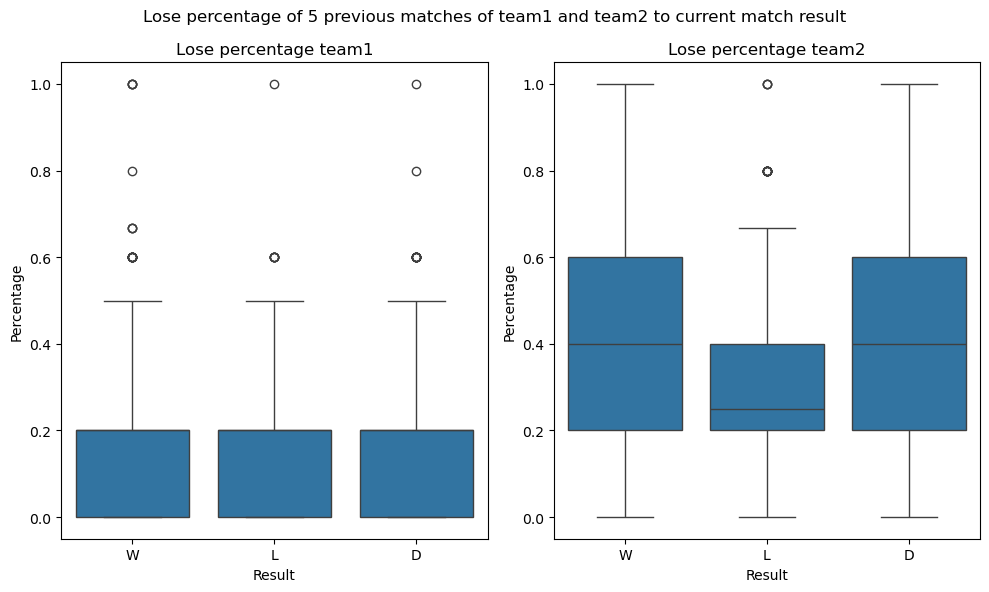

In [14]:
# # Vẽ biểu đồ box plot thể hiện ảnh hưởng của tỷ lệ thua 5 trận trước đó của 2 team đến kết quả trận đấu
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
order = ["W", "L", "D"]

sns.boxplot(
    x="result", y="lose_before_team1", data=mu_df, ax=axes[0], order=["W", "L", "D"]
)
axes[0].set_title('Lose percentage team1')
axes[0].set_xlabel('Result')
axes[0].set_ylabel('Percentage')

sns.boxplot(
    x="result", y="lose_before_team2", data=mu_df, ax=axes[1], order=["W", "L", "D"]
)
axes[1].set_title('Lose percentage team2')
axes[1].set_xlabel('Result')
axes[1].set_ylabel('Percentage')

plt.suptitle("Lose percentage of 5 previous matches of team1 and team2 to current match result")
plt.tight_layout()

Vậy sẽ đưa các biến: `win_before_team2`, `draw_before_team1`, `lose_before_team2` vào quá trình training

### 4. Xem sét sự ảnh hưởng của opponent đến kết quả

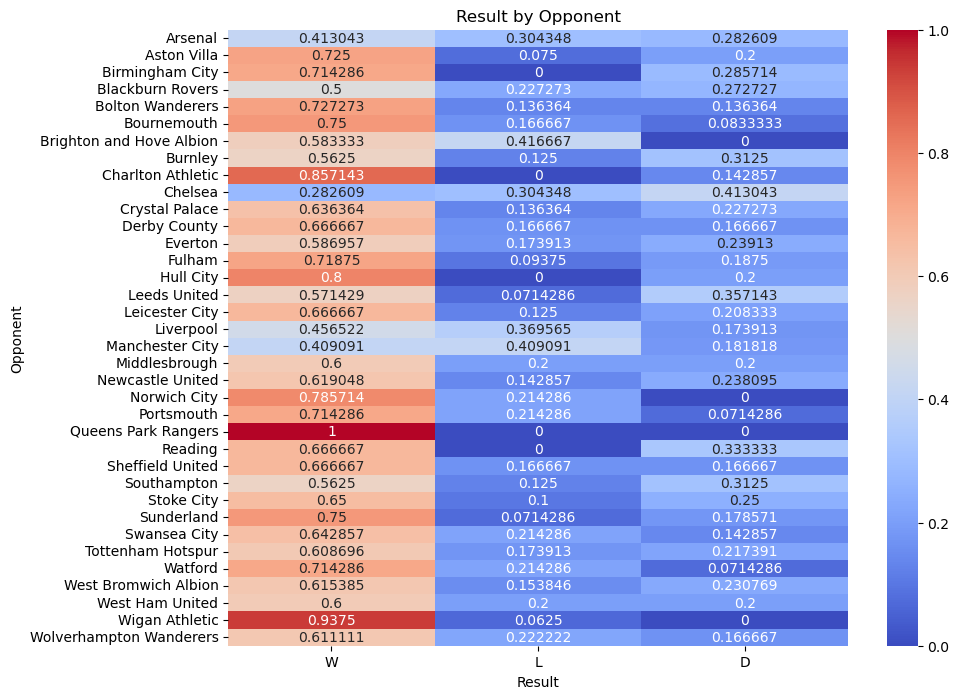

In [15]:
# Tạo bảng dữ liệu cho heatmap
min_usage = 5 
popular_formations = mu_df['opponent'].value_counts()[mu_df['opponent'].value_counts() > min_usage].index
filtered_df = mu_df[mu_df['opponent'].isin(popular_formations)]

# Tính toán tỷ lệ phần trăm thay vì số trận
formation_result = filtered_df.groupby(['opponent', 'result']).size().unstack().fillna(0).reindex(columns=["W", "L", "D"])
formation_result = formation_result.div(filtered_df.groupby(['opponent']).size(), axis=0)

# Vẽ biểu đồ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(formation_result, annot=True, cmap='coolwarm', fmt='g')
plt.title('Result by Opponent')
plt.xlabel('Result')
plt.ylabel('Opponent');

Nhận xét: 
- Tỉ lệ thắng, thua, hoà khi đấu với 1 đối thủ nào đó thường có:
    + Tỉ lệ thắng, hoà cao hơn tỉ lệ thua
    + Chỉ có một số trường hợp đặc biệt tỉ lệ thua cao hơn tỉ lệ thắng và hoà
    là khi đấu với Liverpool và Manchester city. Nên có thể biến đổi cột Opponent này thành 1 biến mới trong quá trình training

### 5. Xem xét sự ảnh hưởng của Formation đến kết quả thi đấu

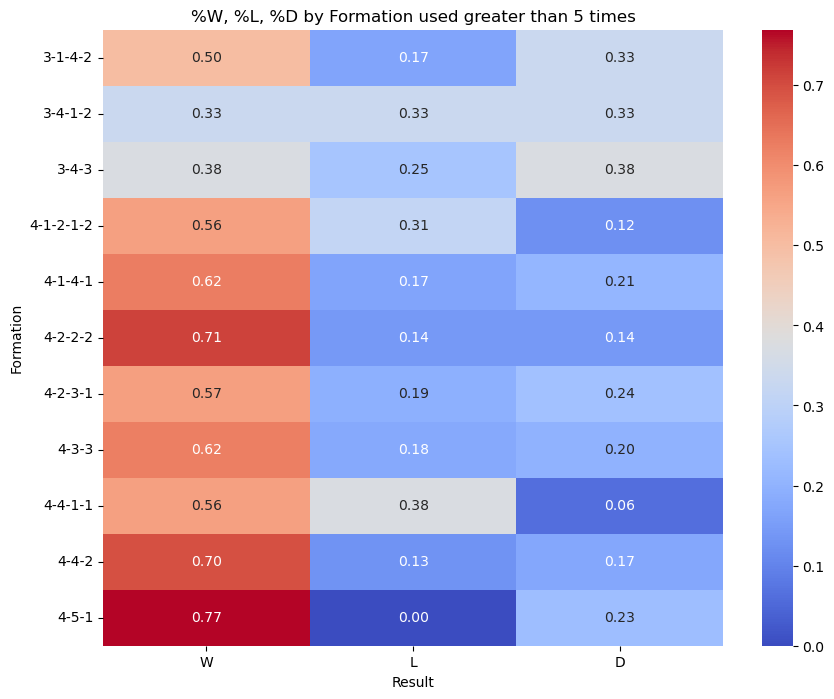

In [16]:
# Lọc dữ liệu để chỉ chọn các đội hình được sử dụng hơn 5 lần
min_usage = 5 
popular_formations = mu_df['formation_team1'].value_counts()[mu_df['formation_team1'].value_counts() > min_usage].index
filtered_df = mu_df[mu_df['formation_team1'].isin(popular_formations)]

# Tính toán tỷ lệ phần trăm thay vì số trận
formation_result = filtered_df.groupby(['formation_team1', 'result']).size().unstack().fillna(0).reindex(columns=["W", "L", "D"])
formation_result = formation_result.div(filtered_df.groupby(['formation_team1']).size(), axis=0)

# Vẽ biểu đồ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(formation_result, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('%W, %L, %D by Formation used greater than 5 times')
plt.xlabel('Result')
plt.ylabel('Formation')
plt.show()

Nhận xét: 
- Có thể thấy sự khác biệt về tỉ lệ của biến `formation` đến `result`:
    + Thông thường khi dùng các đội hình thì tỉ lệ thắng lại cao hơn tỉ lệ thua và hoà. Nhưng tỉ lệ thua và hoà đôi lúc cái này cao hơn cái kia
    + Có một số đội hình khi dùng thì lại cho tỉ lệ thua hoặc hoà lại cao nhất
    
Do đó sẽ đưa biến `formation` vào quá trình training

### 6. Xem xét sự ảnh hưởng của round đến kết quả

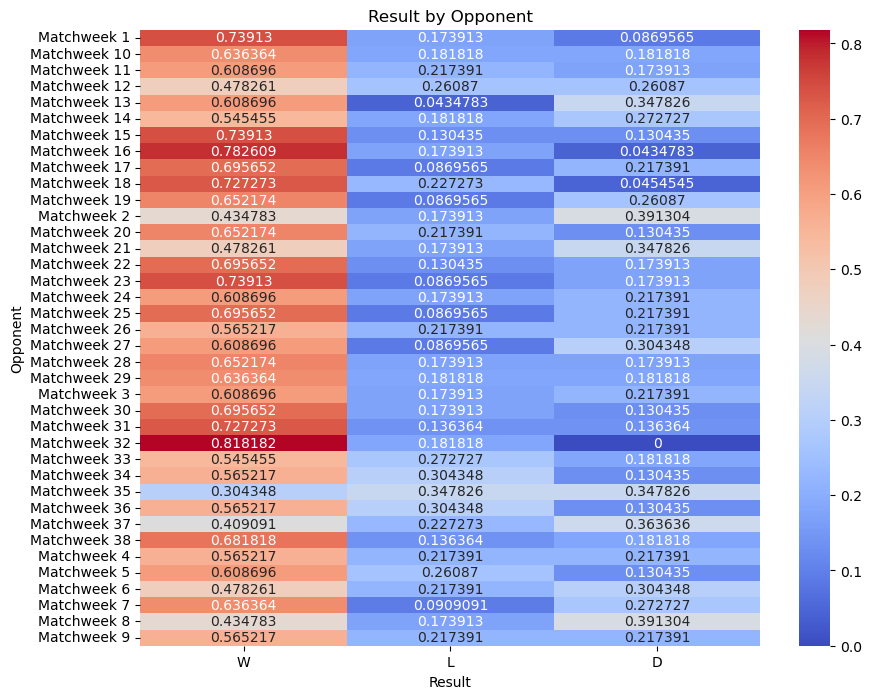

In [17]:
# Tính toán tỷ lệ phần trăm thay vì số trận
formation_result = filtered_df.groupby(['round', 'result']).size().unstack().fillna(0).reindex(columns=["W", "L", "D"])
formation_result = formation_result.div(filtered_df.groupby(['round']).size(), axis=0)

# Vẽ biểu đồ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(formation_result, annot=True, cmap='coolwarm', fmt='g')
plt.title('Result by Opponent')
plt.xlabel('Result')
plt.ylabel('Opponent');

C:\Users\Think Pad\AppData\Local\Temp\ipykernel_11484\148815645.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  round_group_result_percentage = mu_df.groupby('round_group')['result'].value_counts(normalize=True).unstack().fillna(0)


<Figure size 1200x600 with 0 Axes>

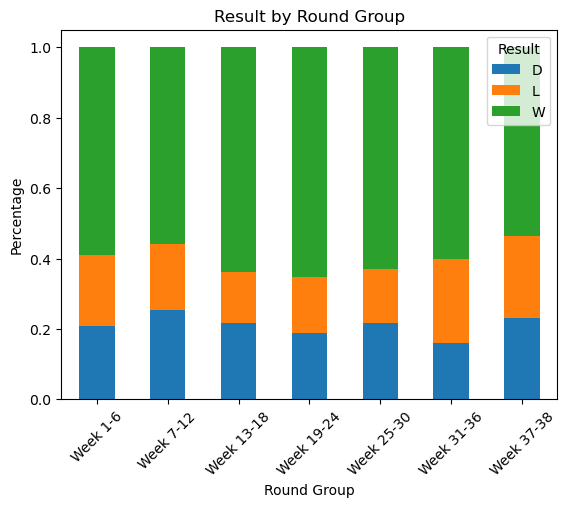

In [18]:
# Trích xuất số từ giá trị chuỗi của cột "round"
mu_df['week'] = mu_df['round'].str.extract(r'(\d+)').astype(int)

# Tạo các nhóm lớn hơn cho các vòng đấu
bins = [1, 6, 12, 18, 24, 30, 36, 39]  # Gom mỗi 6 vòng đấu thành một nhóm
labels = ['Week 1-6', 'Week 7-12', 'Week 13-18', 'Week 19-24', 'Week 25-30', 'Week 31-36', 'Week 37-38']
mu_df['round_group'] = pd.cut(mu_df['week'], bins=bins, labels=labels, right=False)

# Tính toán tỷ lệ phần trăm thắng, hòa, thua theo nhóm vòng đấu
round_group_result_percentage = mu_df.groupby('round_group')['result'].value_counts(normalize=True).unstack().fillna(0)

# Vẽ biểu đồ bar chart
plt.figure(figsize=(12, 6))
round_group_result_percentage.plot(kind='bar', stacked=True)
plt.title('Result by Round Group')
plt.xlabel('Round Group')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Result');

Nhận xét:
- Tỉ lệ thắng luôn cao hơn tỉ lệ thua, hoà và tỉ lệ thua đại đa số cao hơn tỉ lệ hoà<br/>
Do đó có thể thấy tỉ lệ thắng, thua, hoà không có sự thay đổi theo vòng đấu, do đó sẽ loại bỏ biến round ra khỏi quá trình training

### 7. Ảnh hưởng của lịch sử đối đầu đến biến result

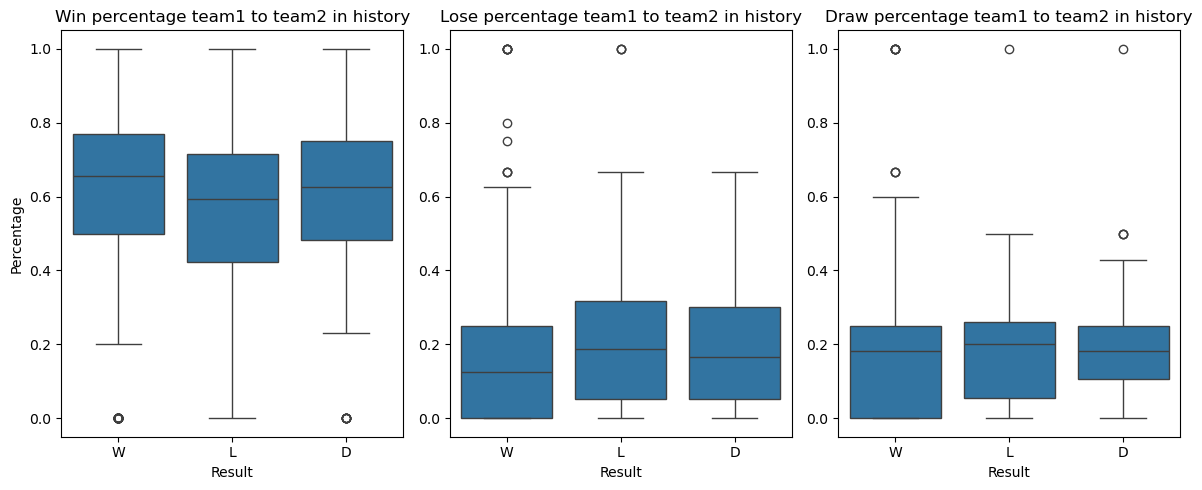

In [19]:
# Vẽ biểu đồ box plot thể hiện ảnh hưởng của tỷ lệ thắng 5 trận trước đó của 2 team đến kết quả trận đấu
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
order = ['W', 'L', 'D']

sns.boxplot(x='result', y='history_team1_win_team2', data=mu_df, ax=axes[0], order=order)
axes[0].set_title('Win percentage team1 to team2 in history')
axes[0].set_xlabel('Result')
axes[0].set_ylabel('Percentage')

sns.boxplot(x='result', y='history_team1_lose_team2', data=mu_df, ax=axes[1], order=order)
axes[1].set_title('Lose percentage team1 to team2 in history')
axes[1].set_xlabel('Result')
axes[1].set_ylabel(None)

sns.boxplot(x='result', y='history_team1_draw_team2', data=mu_df, ax=axes[2], order=order)
axes[2].set_title('Draw percentage team1 to team2 in history')
axes[2].set_xlabel('Result')
axes[2].set_ylabel(None)

plt.tight_layout()

Nhận xét:
- Khi team1 có %W gặp team2 trước đây cao thì tỉ lệ thắng, hoà của team1 khi đấu với team2 trong trận tiếp theo sẽ cao và tỉ lệ thua thấp
- Tỉ lệ thua khi đội 1 gặp đội 2 không ảnh hưởng đáng kể đến result
- Thường các trận đấu mà team1 có %D khi gặp đội kia cao thì khả năng trận đó sẽ hoà cao, còn tỉ lệ thắng/thua sẽ ngang nhau

Vậy sẽ đưa `history_team1_win_team2`, `history_team1_draw_team2` vào quá trình training vì nó có ảnh hưởng đến kết quả trận đấu

### 8. Xem xét sự ảnh hưởng của biến is_opponent_big6 đến kết quả

In [20]:
result_count = mu_df.groupby(['is_opponent_big6', 'result']).size().unstack().reindex(["W", "L", "D"], axis=1)
is_big6_count = mu_df.groupby(['is_opponent_big6']).size()

result_count, is_big6_count

(result              W   L    D
 is_opponent_big6              
 0                 431  90  125
 1                  99  71   58,
 is_opponent_big6
 0    646
 1    228
 dtype: int64)

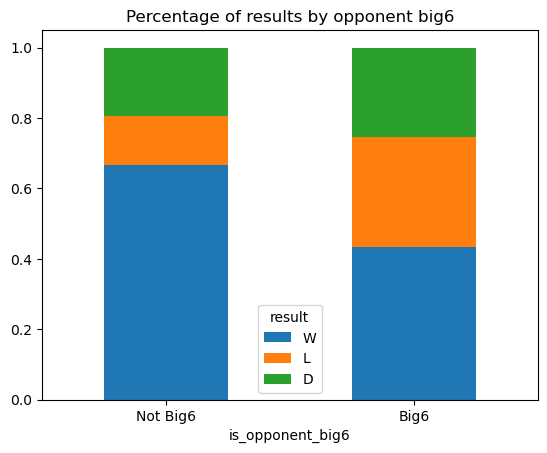

In [21]:
result_percentage = result_count.div(is_big6_count, axis=0)
result_percentage.plot(kind='bar', stacked=True)
plt.title("Percentage of results by opponent big6")
plt.xticks(ticks=[0, 1], labels=['Not Big6', 'Big6'], rotation=0);

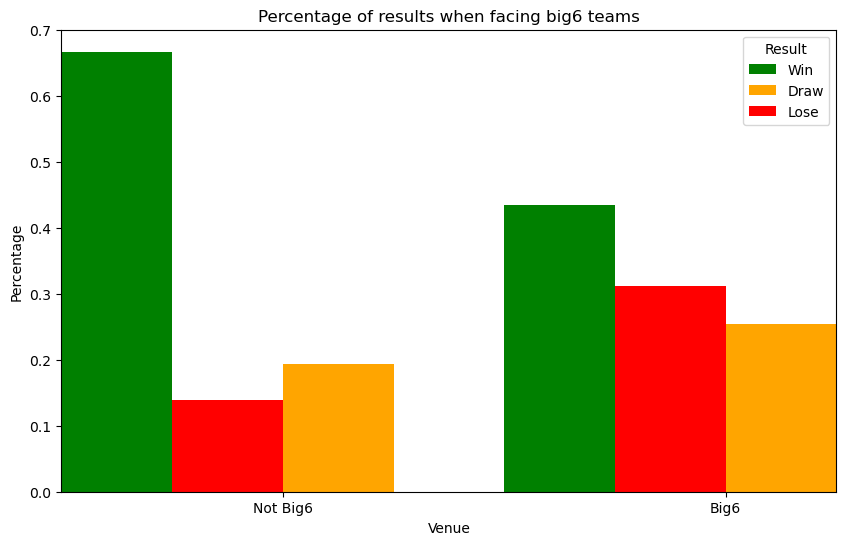

In [22]:
# Thay vì gôm W, L, D vào 1 cột thì ta sẽ tách ra:
fig, ax = plt.subplots(figsize=(10, 6))

# Vẽ biểu đồ cho kết quả Win
result_percentage['W'].plot(kind='bar', ax=ax, color='green', position=2, width=0.25, label='Win')

# Vẽ biểu đồ cho kết quả Draw
result_percentage['D'].plot(kind='bar', ax=ax, color='orange', position=0, width=0.25, label='Draw')

# Vẽ biểu đồ cho kết quả Lose
result_percentage['L'].plot(kind='bar', ax=ax, color='red', position=1, width=0.25, label='Lose')

plt.title("Percentage of results when facing big6 teams")
plt.xlabel("Venue")
plt.ylabel("Percentage")
plt.xticks(ticks=[0, 1], labels=['Not Big6', 'Big6'], rotation=0);
plt.legend(title='Result')

plt.show()

Nhận xét:
- Khi không gặp Big6 thì tỉ lệ thắng cao rõ rệt, tỉ lệ hoà cũng cao hơn tỉ lệ thua
- Khi gặp Big6 thì tỉ lệ thắng/thua ngang nhau và cao hơn tỉ lệ hoà.

Vậy is_opponent_big6 ảnh hưởng rõ rệt đến kết quả thi đấu của trận hiện tại, do đó sẽ đưa đặc trưng này vào việc dự đoán.

### Kết luận
Các đặc trưng sẽ dùng cho việc dự đoán:
- venue
- Các đặc trưng về phong độ 2 đội: `win_before_team2`, `draw_before_team1`, `lose_before_team2`
- formation
- opponent: khả năng sẽ biến đổi thành 1 cột mới
- Các đặc trưng về lịch sử đối đầu: `history_team1_win_team2`, `history_team1_draw_team2`
- is_opponent_big6
- Cột date_time vẫn sẽ giữ lại nhưng không đưa vào dự đoán vì mục đích là dùng để tính toán phong độ, <br/>
lịch sử đối đầu tại giai đoạn test